# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
import numpy as np
import pandas as pd
import os
import random

from collections import Counter

from pathlib import Path
from PIL import Image
import pickle
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from tqdm.notebook import tqdm
import time

from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/My\ Drive/simpsons/simpsons_data -d train
!unzip -q /content/gdrive/My\ Drive/simpsons -d test

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('test/testset')
DATA_MODES = ['train', 'val', 'test']
BATCH_SIZE = 256
RESCALE_SIZE = 224
N_CORES = 2
EPOCHS = 20

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, random_state = SEED)

In [ ]:
data = pd.Series(train_val_labels).value_counts().sort_values().to_frame("count")
data

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Nov 27 15:06:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

In [ ]:
train_labels = [path.parent.name for path in train_files]
pd.Series(train_labels).value_counts().sort_values().to_frame("count")

,count
lionel_hutz,2
troy_mcclure,6
disco_stu,6
miss_hoover,13
fat_tony,20
gil,20
otto_mann,24
sideshow_mel,30
agnes_skinner,32
rainier_wolfcastle,34


Давайте посмотрим на наших героев внутри датасета.

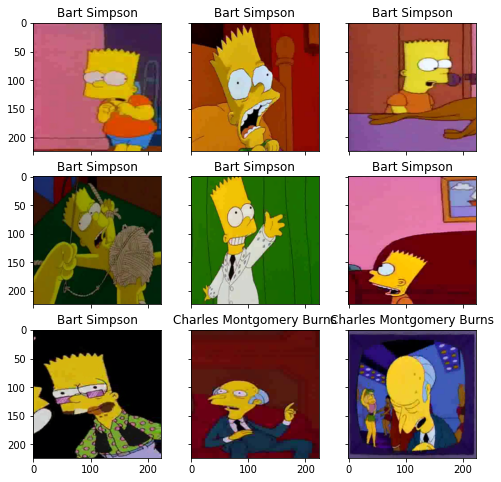

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 3.052441750751862

Epoch 001 train_loss: 3.0524     val_loss 2.7382 train_acc 0.1297 val_acc 0.2098
loss 2.465176577643685

Epoch 002 train_loss: 2.4652     val_loss 2.1487 train_acc 0.3122 val_acc 0.4213
loss 1.924645994892469

Epoch 003 train_loss: 1.9246     val_loss 1.7918 train_acc 0.4633 val_acc 0.5099
loss 1.52766260421005

Epoch 004 train_loss: 1.5277     val_loss 1.4938 train_acc 0.5762 val_acc 0.6030
loss 1.202126917295968

Epoch 005 train_loss: 1.2021     val_loss 1.2415 train_acc 0.6679 val_acc 0.6729
loss 0.9552958364418049

Epoch 006 train_loss: 0.9553     val_loss 1.0926 train_acc 0.7357 val_acc 0.7134
loss 0.7493058427958528

Epoch 007 train_loss: 0.7493     val_loss 1.0155 train_acc 0.7884 val_acc 0.7379
loss 0.5845183975848888

Epoch 008 train_loss: 0.5845     val_loss 1.0222 train_acc 0.8344 val_acc 0.7411
loss 0.48415257795364725

Epoch 009 train_loss: 0.4842     val_loss 0.9892 train_acc 0.8599 val_acc 0.7629
loss 0.37628270194282787

Epoch 010 train_loss: 0.3

Сопоставив лосс и точность по обучающей и валидационной выборкам в рамках эпох, можем видеть, что на 10-й эпохе начинается переобучение. Оно почти наверное связано с несбалансированностью данных, наличием малых выборок по некоторым классам, а вдовесок ко всему мы еще и разделили всю выборку на обучающую и валидационную в соотношении 3/1, т.е. урезали обучающую выборку на 25%. В итоге на валидации видно, что модель не способна работать с новым набором данных по некоторым классам. Точность модели в целом неплохая даже на валидации, но это очевидно не то, что мы хотели бы видеть. Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

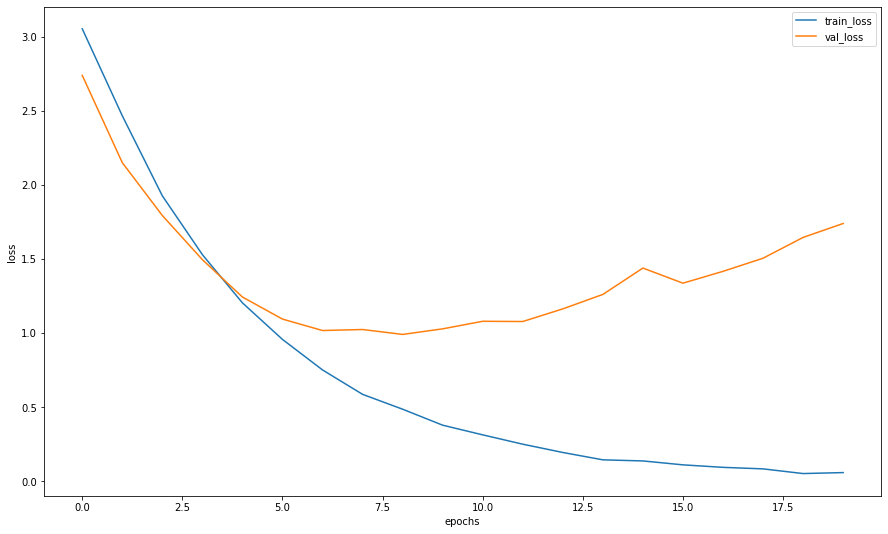

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
f1_score(actual_labels, y_pred, average="micro")

0.8000000000000002

Для сабмита создадим функцию и будем ее вызывать после каждой модели, не забывая перед повторным применением предварительно скачать сабмит с диска.

In [ ]:
def submission(model, test_dataset, batch_size=BATCH_SIZE, output_path='/content/gdrive/MyDrive/simpsons/my_submit.csv'):
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    probs = predict(model, test_loader)

    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))   # инверсивно трансформим из цифорок классов в string
    test_filenames = [path.name for path in test_dataset.files]

    my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
    print(my_submit.head())
    my_submit.to_csv(output_path, index=False)

In [ ]:
submission(model=simple_cnn, test_dataset=test_dataset)

           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

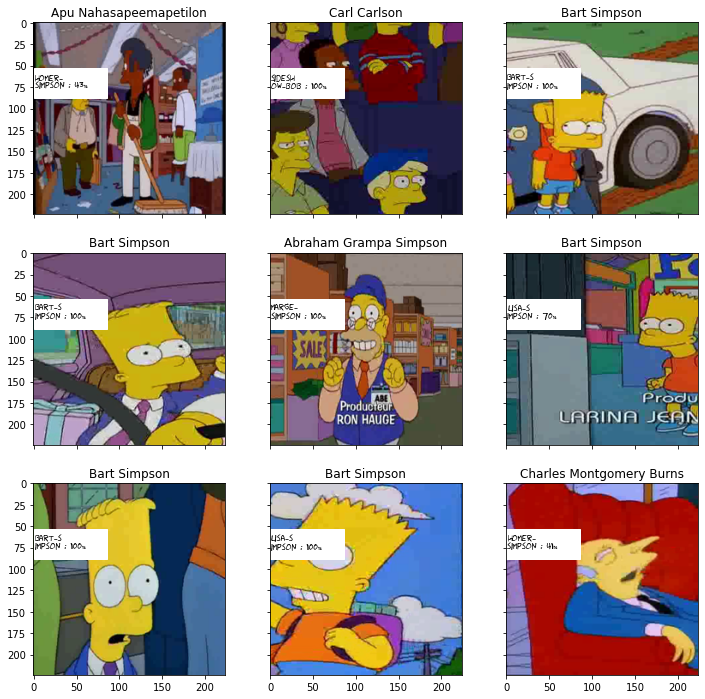

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

##Аугментация
Про несбалансированность выборки уже было сказано ранее, однако для наглядности визуализируем эту информацию и оценим её экспрессию.

In [ ]:
def show_data(data, min_level=True, max_level=True):
    plt.figure(figsize=(15, 9))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
    if max_level:
        plt.axhline(y=2100)
    if min_level:
        plt.axhline(y=100, color='red')
    plt.show()

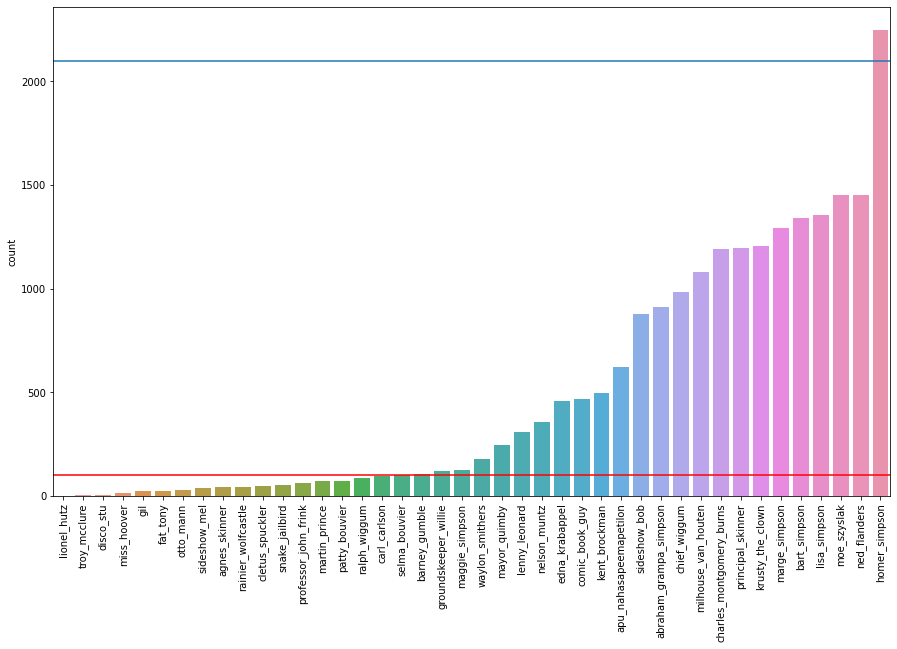

In [ ]:
show_data(data)

С подобным распределением помогает бороться аугментация, которая позволяет увеличить объём выборки и повысить устойчивость модели к некоторым преобразованиям.

In [ ]:
class SimpsonsDataset_v2(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа

        if self.mode == "train":
            aug_tr = transforms.Compose([
                                    transforms.Resize(size=300, max_size=301),
                                    transforms.CenterCrop(size=300),
                                    transforms.RandomCrop(250),
                                    transforms.RandomRotation(degrees=(-25, 25)),
                                    transforms.RandomHorizontalFlip(p=1),
                                ])
            transform = transforms.Compose([
                                    aug_tr,
                                    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                                    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

        else:
            transform = transforms.Compose([
                        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                        transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

        x = self.load_sample(self.files[index])
        #x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
aug_train_dataset = SimpsonsDataset_v2(train_files, mode='train')
aug_val_dataset = SimpsonsDataset_v2(val_files, mode='val')
aug_test_dataset = SimpsonsDataset_v2(test_files, mode='test')

Попытаемся добиться распределения данных, близкого к равномерному, для чего инициализируем веса по принципу чем меньше выборка для конкретного класса, тем больше вес.

In [ ]:
class_count = Counter(aug_train_dataset.labels)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(aug_train_dataset)
for i, label in enumerate(tqdm(aug_train_dataset.labels)):
  class_weight = class_weights[label]
  sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(aug_train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=N_CORES)

  0%|          | 0/15699 [00:00<?, ?it/s]

In [ ]:
count = Counter()
for data, labels in tqdm(train_loader):
  count += Counter(labels.tolist())
print(sum(count.values()), count)

  0%|          | 0/277 [00:00<?, ?it/s]

70728 Counter({18: 1772, 20: 1768, 4: 1760, 17: 1752, 25: 1752, 14: 1742, 35: 1740, 34: 1738, 28: 1735, 15: 1720, 24: 1719, 7: 1705, 33: 1702, 30: 1699, 3: 1698, 36: 1695, 12: 1693, 8: 1690, 38: 1690, 31: 1690, 2: 1684, 39: 1682, 37: 1681, 0: 1677, 40: 1674, 9: 1662, 22: 1662, 29: 1655, 6: 1652, 5: 1648, 21: 1648, 16: 1648, 19: 1644, 23: 1642, 32: 1642, 41: 1638, 26: 1637, 11: 1637, 27: 1637, 1: 1622, 10: 1614, 13: 1582})


Распределение данных почти равномерно.

In [ ]:
def aug_train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(aug_train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=N_CORES)
    val_loader = DataLoader(aug_val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
history = aug_train(aug_train_dataset, aug_val_dataset, model=simple_cnn, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.146706938918879

Epoch 001 train_loss: 2.1467     val_loss 1.9755 train_acc 0.4454 val_acc 0.4692
loss 0.949514053752689

Epoch 002 train_loss: 0.9495     val_loss 1.5000 train_acc 0.7454 val_acc 0.6177
loss 0.6421478501327328

Epoch 003 train_loss: 0.6421     val_loss 1.3904 train_acc 0.8261 val_acc 0.6429
loss 0.524705885472226

Epoch 004 train_loss: 0.5247     val_loss 1.2620 train_acc 0.8553 val_acc 0.6832
loss 0.43639990743664697

Epoch 005 train_loss: 0.4364     val_loss 1.1354 train_acc 0.8782 val_acc 0.7100
loss 0.3800967006614718

Epoch 006 train_loss: 0.3801     val_loss 1.1562 train_acc 0.8943 val_acc 0.7211
loss 0.33004619381726025

Epoch 007 train_loss: 0.3300     val_loss 1.1063 train_acc 0.9058 val_acc 0.7373
loss 0.2924149840170139

Epoch 008 train_loss: 0.2924     val_loss 1.0236 train_acc 0.9162 val_acc 0.7572
loss 0.2741266957671377

Epoch 009 train_loss: 0.2741     val_loss 0.9962 train_acc 0.9220 val_acc 0.7619
loss 0.24238059457617775

Epoch 010 train_loss:

Точность модели повысилась и переобучения в целом не наблюдается, имеются некоторые выбросы, но на дистанции в 20 эпох и более они благополучно ликвидируются. Действительно, предположение о том, что переобучение связано с недостаточной статистикой по классам, вполне приемлемо.

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

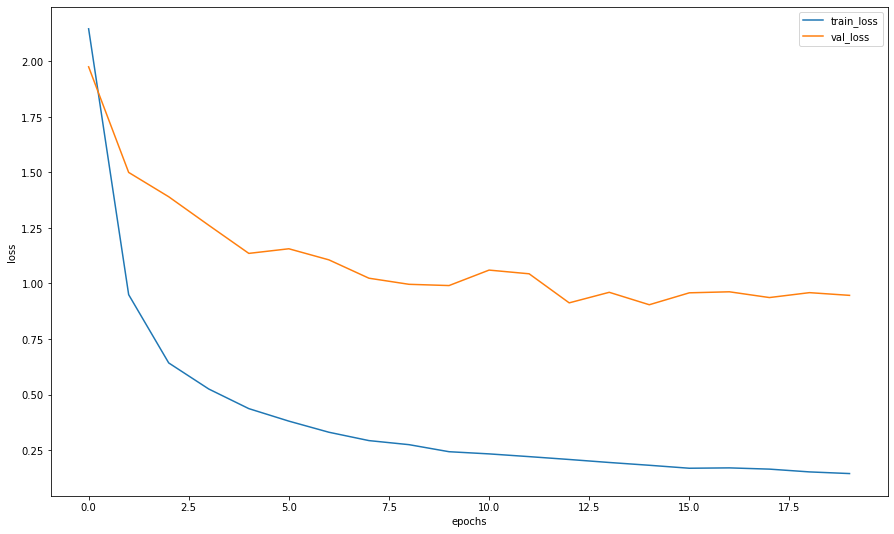

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = aug_val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [aug_val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [aug_val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
f1_score(actual_labels, y_pred, average="micro")

0.7

Однако скор ниже, чем это было ранее.

In [ ]:
submission(model=simple_cnn, test_dataset=aug_test_dataset)

           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon


Поверим, что теперь статистики по каждому классу достаточно, т.к. в целом удалось избежать переобучения на аугментированном датасете (несмотря на то, что скор оказался ниже). Так что попробуем обучить чуть более сложную модель на всей выборке, т.е. без валидации.

In [ ]:
aug = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    aug,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
aug_train_data = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

Попытаемся добиться распределения данных, близкого к равномерному, для чего инициализируем веса по принципу чем меньше выборка для конкретного класса, тем больше вес.

In [ ]:
class_count = Counter(aug_train_data.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(aug_train_data)
for i, (data, label) in enumerate(tqdm(aug_train_data)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(aug_train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=N_CORES)

  0%|          | 0/20933 [00:00<?, ?it/s]

In [ ]:
count = Counter()
for data, labels in tqdm(train_loader):
    count += Counter(labels.tolist())
print(sum(count.values()), count)

  0%|          | 0/369 [00:00<?, ?it/s]

94332 Counter({17: 2351, 28: 2329, 18: 2313, 25: 2305, 4: 2301, 20: 2299, 38: 2294, 33: 2294, 24: 2286, 2: 2284, 14: 2278, 23: 2275, 34: 2272, 37: 2271, 15: 2268, 35: 2266, 9: 2263, 16: 2260, 30: 2254, 39: 2253, 40: 2251, 11: 2247, 3: 2245, 7: 2241, 12: 2240, 21: 2238, 6: 2233, 0: 2225, 10: 2224, 8: 2220, 5: 2212, 32: 2210, 22: 2206, 29: 2204, 26: 2194, 27: 2190, 31: 2186, 1: 2186, 41: 2184, 19: 2176, 36: 2165, 13: 2139})


Распределение данных почти равномерное.

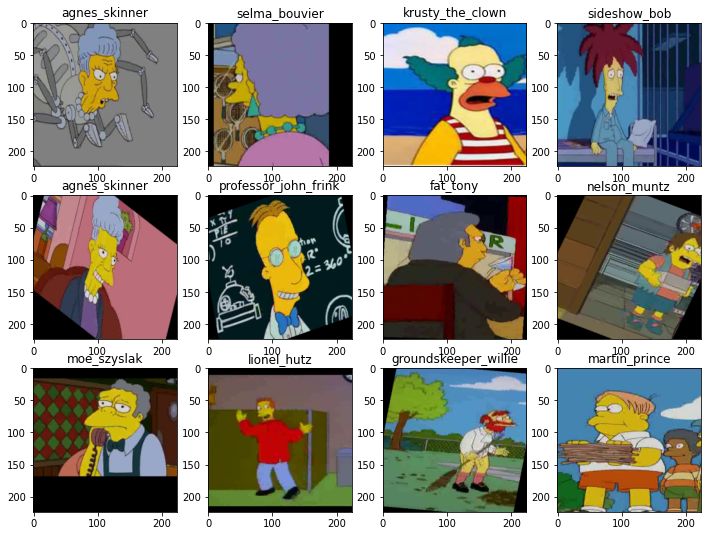

In [ ]:
axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))[1]
data, labels = next(iter(train_loader))
for ax, d, l in zip(axes.flatten(), data, labels):
    imshow(d.data.cpu(), title=aug_train_data.classes[l], plt_ax=ax)

##Модель №1
Немного усложним нашу модель и обучение.

In [ ]:
class Model_1(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv2 = nn.Sequential(
       nn.Conv2d(8, 16, kernel_size=3),
       nn.ReLU(),
       nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(64, 96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    flatten_out = 96 * 5 * 5
    self.out = nn.Linear(in_features=flatten_out, out_features=n_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)

    x = x.flatten(start_dim=1)

    logits = self.out(x)
    return logits

In [ ]:
class_1 = Model_1(n_classes).to(DEVICE)
print(class_1)

Model_1(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_features=42, bias=True)
)


In [ ]:
def fit_epoch_v2(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = F.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def train_v2(model, loss, optimizer, scheduler, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch_v2(model, train_loader, loss, optimizer, scheduler)
            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))

    return history

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(class_1.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
history = train_v2(model=class_1, loss=loss, optimizer=optimizer, scheduler=scheduler, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.7768 train_acc 0.5430

Epoch 002 train_loss: 0.7136 train_acc 0.8114

Epoch 003 train_loss: 0.4810 train_acc 0.8714

Epoch 004 train_loss: 0.3662 train_acc 0.9003

Epoch 005 train_loss: 0.3010 train_acc 0.9182

Epoch 006 train_loss: 0.2653 train_acc 0.9266

Epoch 007 train_loss: 0.2325 train_acc 0.9358

Epoch 008 train_loss: 0.1712 train_acc 0.9532

Epoch 009 train_loss: 0.1505 train_acc 0.9590

Epoch 010 train_loss: 0.1494 train_acc 0.9587

Epoch 011 train_loss: 0.1400 train_acc 0.9616

Epoch 012 train_loss: 0.1369 train_acc 0.9623

Epoch 013 train_loss: 0.1337 train_acc 0.9630

Epoch 014 train_loss: 0.1268 train_acc 0.9648

Epoch 015 train_loss: 0.1251 train_acc 0.9657

Epoch 016 train_loss: 0.1196 train_acc 0.9668

Epoch 017 train_loss: 0.1212 train_acc 0.9667

Epoch 018 train_loss: 0.1248 train_acc 0.9660

Epoch 019 train_loss: 0.1206 train_acc 0.9669

Epoch 020 train_loss: 0.1207 train_acc 0.9672


Визуализируем результаты вычисления лоссов в зависимости от эпохи

In [ ]:
loss, acc = zip(*history)

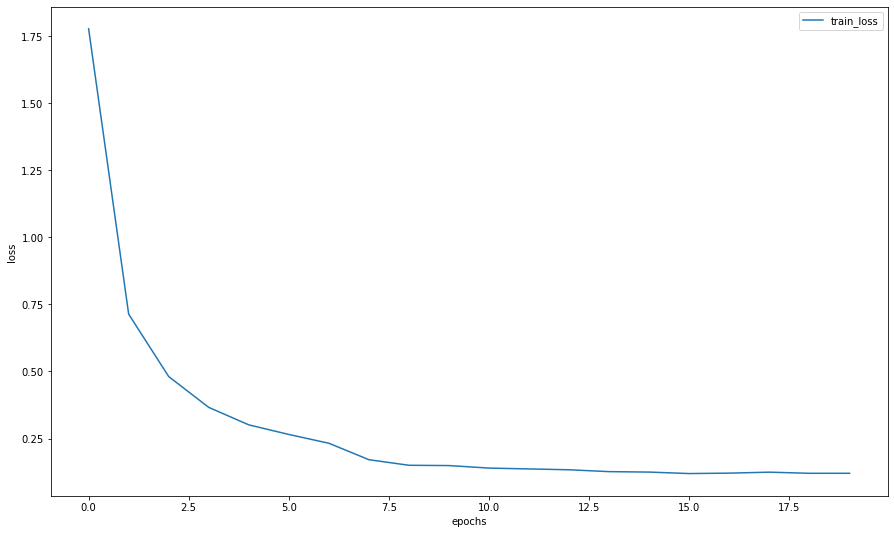

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(class_1, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(class_1, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
f1_score(actual_labels, y_pred, average="micro")

0.9500000000000001

Скор значительно повысился, но он до сих пор нас не устраивает, т.к. мы хотим иметь модель, которая будет выдавать более надежные предикты. Однако отметим позитивные изменения.

In [ ]:
submission(model=class_1, test_dataset=test_dataset)

           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon


##Модель №2
Усложним модель еще больше, добавив 2 полносвязных слоя.

In [ ]:
class Model_2(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv2 = nn.Sequential(
       nn.Conv2d(8, 16, kernel_size=3),
       nn.ReLU(),
       nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(64, 96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.ft = nn.Flatten()

    flatten_out = 96 * 5 * 5

    self.fc1 = nn.Sequential(
        nn.Linear(in_features=flatten_out, out_features=4096, bias=True),
        nn.ReLU(inplace=True)
    )
    self.fc2 = nn.Sequential(
        nn.Linear(in_features=4096, out_features=4096, bias=True),
        nn.ReLU(inplace=True)
    )
    self.out = nn.Linear(in_features=4096, out_features=n_classes, bias=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)

    x = self.ft(x)

    x = self.fc1(x)
    x = self.fc2(x)
    logits = self.out(x)
    return logits

In [ ]:
class_2 = Model_2(n_classes).to(DEVICE)
print(class_2)

Model_2(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ft): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
  

In [ ]:
l = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(class_2.parameters(), amsgrad=True, lr=1e-3)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

In [ ]:
history = train_v2(model=class_2, loss=l, optimizer=opt, scheduler=sched, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.8156 train_acc 0.5084

Epoch 002 train_loss: 0.4245 train_acc 0.8744

Epoch 003 train_loss: 0.2238 train_acc 0.9331

Epoch 004 train_loss: 0.1515 train_acc 0.9544

Epoch 005 train_loss: 0.1094 train_acc 0.9663

Epoch 006 train_loss: 0.0835 train_acc 0.9749

Epoch 007 train_loss: 0.0703 train_acc 0.9788

Epoch 008 train_loss: 0.0347 train_acc 0.9897

Epoch 009 train_loss: 0.0216 train_acc 0.9939

Epoch 010 train_loss: 0.0177 train_acc 0.9950

Epoch 011 train_loss: 0.0157 train_acc 0.9955

Epoch 012 train_loss: 0.0153 train_acc 0.9958

Epoch 013 train_loss: 0.0125 train_acc 0.9965

Epoch 014 train_loss: 0.0106 train_acc 0.9971

Epoch 015 train_loss: 0.0096 train_acc 0.9974

Epoch 016 train_loss: 0.0097 train_acc 0.9972

Epoch 017 train_loss: 0.0093 train_acc 0.9975

Epoch 018 train_loss: 0.0092 train_acc 0.9977

Epoch 019 train_loss: 0.0082 train_acc 0.9977

Epoch 020 train_loss: 0.0084 train_acc 0.9975


In [ ]:
loss, acc = zip(*history)

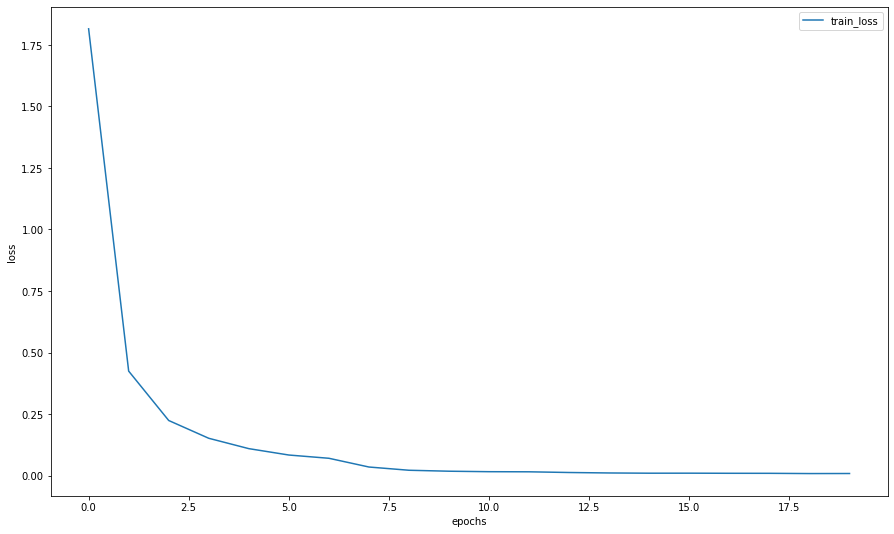

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(class_2, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(class_2, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
f1_score(actual_labels, y_pred, average="micro")

1.0

In [ ]:
submission(model=class_2, test_dataset=test_dataset)

           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon


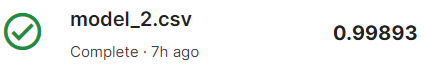

##Модель №2 с BatchNorm и Dropout
Нормализация весов дает разделяющей гиперплоскости большую степень свободы. В семинаре говорилось, что расположение батчнорма — вопрос дискуссионный. Также есть предположение, что расположение батчнорма перед перед выходным слоем может повлиять на предсказания в худшую сторону, т.к. именно по различиям на выходе из предпоследнего слоя происходит классификация.

Дропаут же это зануление случайным образом некоторых (обычно половины от общего количества в слое) нейронов линейных слоев, т.е., по-сути, мы заставляем модель работать на частичном признаковом описанием. Но мы не "выкидываем" зануленные признаки, они просто не вносят вклада в предсказание. Это заставляет модель агрегировать значения всех признаков, "взрывая" лосс мы заставляем модель использовать информацию с остальных признаков. Дропаут в некотором роде можно рассматривать как ансамблирование большого количества сетей, т.к. сначала зануляются одни нейроны сети, затем другие и т.д., а потом все эти подсети накладываются друг на друга и осуществляется предсказание уже всей сетью. По-сути, происходит усреднение огромного количества случайно насэмплированных сетей.

Применим батчнорм после активации (вход в следующий слой будет нормализованным) в сверточных слоях и добавим дропаут для регуляризации в двух линейных fc-слоях.

In [ ]:
class Model_2_with_batchnorm_and_dropout(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv2 = nn.Sequential(
       nn.Conv2d(8, 16, kernel_size=3),
       nn.ReLU(),
       nn.BatchNorm2d(16),
       nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(64, 96, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(96),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.ft = nn.Flatten()

    flatten_out = 96 * 5 * 5

    self.dropout = nn.Dropout()
    self.fc1 = nn.Sequential(
        nn.Linear(in_features=flatten_out, out_features=4096, bias=True),
        nn.ReLU(inplace=True)
    )
    self.fc2 = nn.Sequential(
        nn.Linear(in_features=4096, out_features=4096, bias=True),
        nn.ReLU(inplace=True)
    )
    self.out = nn.Linear(in_features=4096, out_features=n_classes, bias=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)

    x = self.ft(x)

    x = self.dropout(self.fc1(x))
    x = self.fc2(x)
    logits = self.out(x)
    return logits

In [ ]:
class_2_v2 = Model_2_with_batchnorm_and_dropout(n_classes).to(DEVICE)
print(class_2_v2)

Model_2_with_batchnorm_and_dropout(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=

В качестве оптимизатора попробуем adamW

In [ ]:
l = torch.nn.CrossEntropyLoss()
opt = torch.optim.AdamW(class_2_v2.parameters(), amsgrad=True, lr=1e-3)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

In [ ]:
history = train_v2(model=class_2_v2, loss=l, optimizer=opt, scheduler=sched, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 001 train_loss: 0.9118 train_acc 0.7532

Epoch 002 train_loss: 0.3079 train_acc 0.9113

Epoch 003 train_loss: 0.2117 train_acc 0.9397

Epoch 004 train_loss: 0.1635 train_acc 0.9527

Epoch 005 train_loss: 0.1355 train_acc 0.9614

Epoch 006 train_loss: 0.1165 train_acc 0.9662

Epoch 007 train_loss: 0.1078 train_acc 0.9686

Epoch 008 train_loss: 0.0588 train_acc 0.9832

Epoch 009 train_loss: 0.0403 train_acc 0.9880

Epoch 010 train_loss: 0.0345 train_acc 0.9896

Epoch 011 train_loss: 0.0291 train_acc 0.9915

Epoch 012 train_loss: 0.0262 train_acc 0.9919

Epoch 013 train_loss: 0.0228 train_acc 0.9930

Epoch 014 train_loss: 0.0213 train_acc 0.9933

Epoch 015 train_loss: 0.0206 train_acc 0.9938

Epoch 016 train_loss: 0.0198 train_acc 0.9940

Epoch 017 train_loss: 0.0195 train_acc 0.9942

Epoch 018 train_loss: 0.0203 train_acc 0.9940

Epoch 019 train_loss: 0.0187 train_acc 0.9943

Epoch 020 train_loss: 0.0182 train_acc 0.9944


In [ ]:
loss, acc = zip(*history)

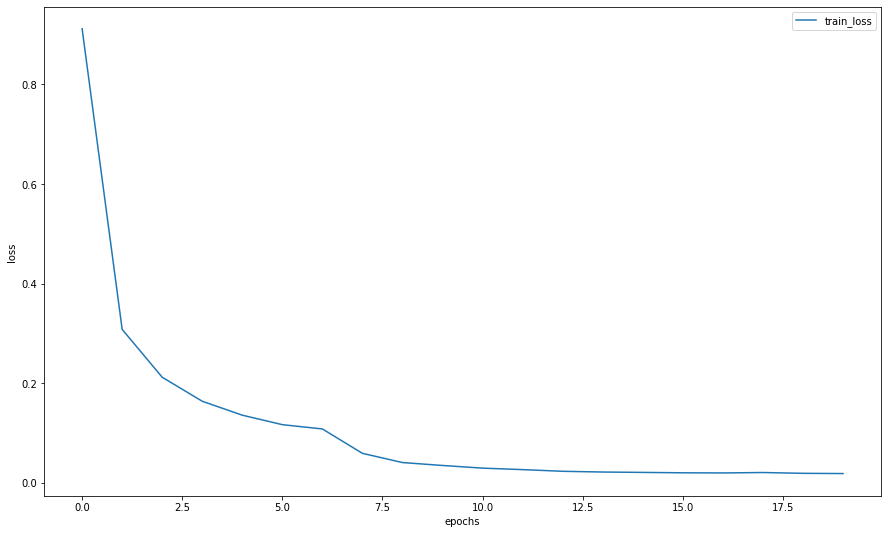

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

В целом, начиная с 13-й эпохи, можно заметить, что модель сходится, т.к. серьезных приращений в её качестве не наблюдается.

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(class_2_v2, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(class_2_v2, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
f1_score(actual_labels, y_pred, average="micro")

1.0

In [ ]:
submission(model=class_2_v2, test_dataset=test_dataset)

           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon


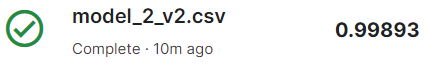

Применение батчнорма и дропаута не позволило добиться повышения скора.

##Модель №3

In [ ]:
from tqdm import tqdm, tqdm_notebook

train_dir = Path('/content/train/train/simpsons_dataset')
test_dir = Path('/content/test/testset')
train_files = sorted(list(train_dir.rglob('*.jpg')))
test_files = sorted(list(test_dir.rglob('*.jpg')))

train_labels = [path.parent.name for path in train_files]

In [ ]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [ ]:
modes = ['train', 'test']

class Simpsons(Dataset):
    def __init__(self, files, mode):
        self.files = files
        self.mode = mode
        self.len_ = len(self.files)

        if self.mode not in modes:
            print(f'{self.mode} incorrect. Use actual in {modes}.')
            raise NameError

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('le.pickle', 'wb') as dumped_file:
                pickle.dump(self.label_encoder, dumped_file)

    def __len__(self):
        return self.len_

    def load_img(self, file):
        img = Image.open(file)
        img.load()
        return img

    def __getitem__(self, idx):
        if self.mode == 'test':
            transform = transforms.Compose([
                transforms.Resize(size=(224,224), antialias=True),
                transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            augmentation = transforms.RandomChoice([
                transforms.Compose([
                    transforms.Resize(size=300, max_size=301),
                    transforms.CenterCrop(size=300),
                    transforms.RandomCrop(250)
                ]),
                transforms.RandomRotation(degrees=(-25,25)),
                transforms.RandomHorizontalFlip(p=1)
            ])
            transform = transforms.Compose([
                augmentation,
                transforms.Resize(size=(224,224), antialias=True),
                transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        file = self.files[idx]
        x = self.load_img(file)
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[idx]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x,y

In [ ]:
train_dataset = Simpsons(train_files, mode='train')
test_dataset = Simpsons(test_files, mode='test')

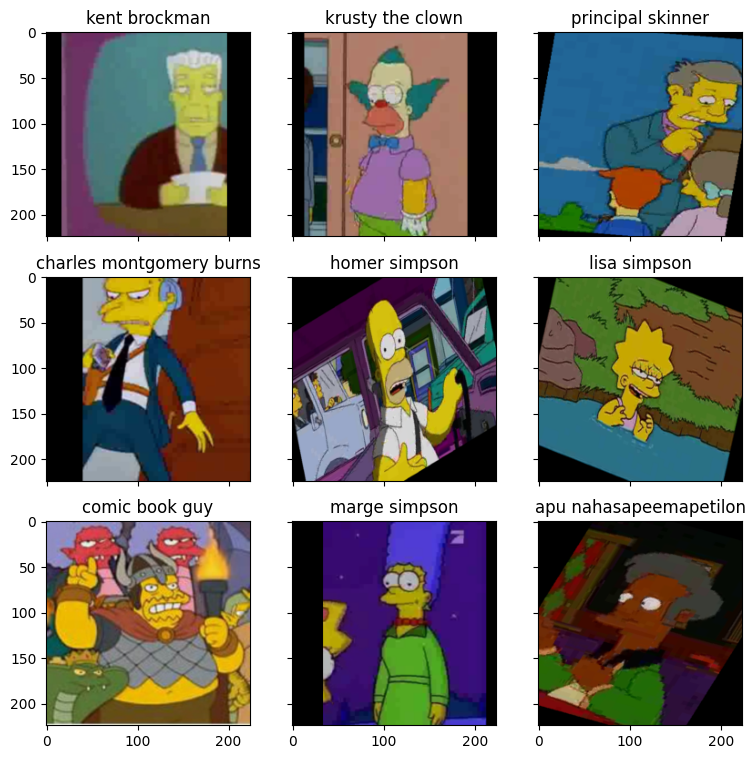

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
fig, ax = plt.subplots(figsize=(9,9), sharey=True, sharex=True,
                       nrows=3, ncols=3)

for figx in ax.ravel():
    random_character = np.array(np.random.uniform(20000), dtype='int').item()
    img, label = train_dataset[random_character]
    img = img.permute(1,2,0)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    figx.set_title(" ".join(train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    figx.imshow(img)

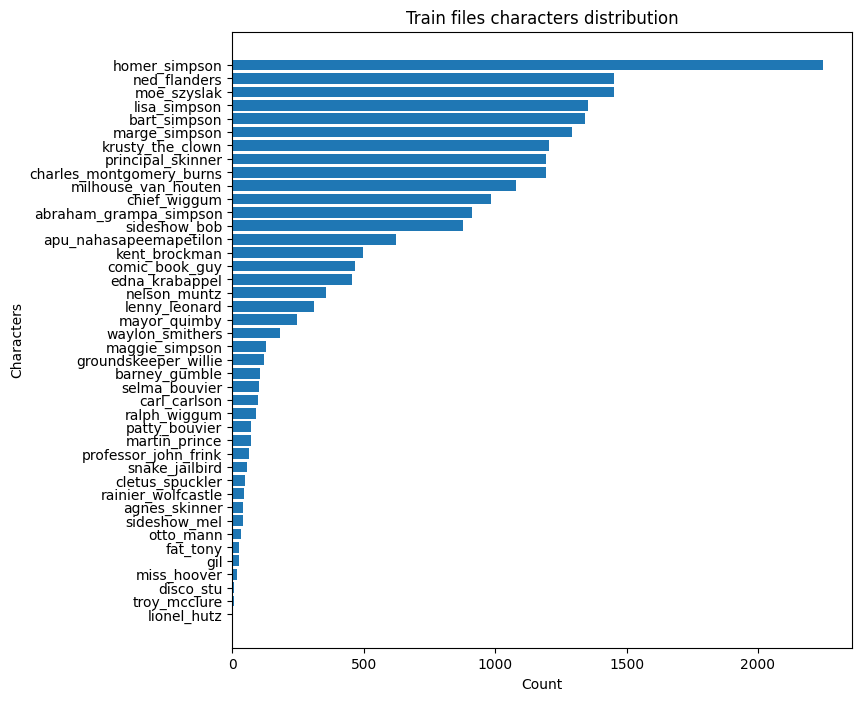

In [ ]:
counts = pd.Series(train_labels).value_counts()

plt.figure(figsize=(8,8))
plt.barh(counts.keys()[::-1], counts.sort_values(ascending=True))
plt.title('Train files characters distribution')
plt.xlabel('Count')
plt.ylabel('Characters')
plt.show();

In [ ]:
count_weights = {k: 1/v for k,v in counts.items()}
sample_weights = len(train_files) * [0]

for i, (data, label) in enumerate(tqdm(train_dataset)):
    label_weight = count_weights[train_dataset.label_encoder.inverse_transform([label])[0]]
    sample_weights[i] = label_weight

100%|██████████| 20933/20933 [02:30<00:00, 139.42it/s]


In [ ]:
# количество сэмплов для сэмплера
N = counts.max() * len(count_weights)
N

94332

In [ ]:
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N.item(), replacement=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=2)

In [ ]:
class SimpleCNN_v2(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=4800),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=4800),
            nn.ReLU(),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=42)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
n_classes = len(np.unique(train_dataset.labels))
scnn_v2 = SimpleCNN_v2(n_classes).to(DEVICE)
print(scnn_v2)

SimpleCNN_v2(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=2400, out_

In [ ]:
optimizer = torch.optim.Adam(scnn_v2.parameters(), lr=1e-3, amsgrad=True)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
def fit_epoch(model, train_dataloader, criterion, optimizer, scheduler):
    running_loss = 0
    running_corrects = 0
    running_data = 0

    for inputs, label in tqdm_notebook(train_dataloader):
        inputs = inputs.to(DEVICE)
        label = label.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * label.size(0)
        preds = outputs.argmax(-1)
        running_corrects += (preds == label).sum()
        running_data += label.size(0)


    scheduler.step()
    train_acc = running_corrects / running_data
    train_loss = running_loss / running_data

    return train_loss, train_acc

In [ ]:
def train(model,epochs,batch_size,train_dataloader):

    history = []

    log_template = '   Epoch - {ep: 03d}, train loss: {tr_loss: 0.4f}, train acc: {tr_acc: 0.4f}'

    with tqdm(desc='Epoch', total=epochs) as pbar:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_dataloader, criterion, optimizer, scheduler)
            history.append((train_loss, train_acc))
            pbar.update(1)
            tqdm.write(log_template.format(ep=epoch+1, tr_loss = train_loss, tr_acc = train_acc))

    return history

In [ ]:
epochs=20
batch_size=128

history = train(scnn_v2, epochs, batch_size, train_dataloader)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:   5%|▌         | 1/20 [08:03<2:33:12, 483.81s/it]

   Epoch -  01, train loss:  1.5397, train acc:  0.5806


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  10%|█         | 2/20 [16:01<2:24:04, 480.24s/it]

   Epoch -  02, train loss:  0.3997, train acc:  0.8845


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  15%|█▌        | 3/20 [24:01<2:15:59, 479.99s/it]

   Epoch -  03, train loss:  0.2323, train acc:  0.9318


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  20%|██        | 4/20 [32:02<2:08:06, 480.39s/it]

   Epoch -  04, train loss:  0.1636, train acc:  0.9524


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  25%|██▌       | 5/20 [40:04<2:00:18, 481.22s/it]

   Epoch -  05, train loss:  0.1238, train acc:  0.9629


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  30%|███       | 6/20 [48:02<1:51:59, 479.98s/it]

   Epoch -  06, train loss:  0.0624, train acc:  0.9816


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  35%|███▌      | 7/20 [56:08<1:44:25, 482.00s/it]

   Epoch -  07, train loss:  0.0414, train acc:  0.9881


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  40%|████      | 8/20 [1:04:04<1:36:01, 480.11s/it]

   Epoch -  08, train loss:  0.0351, train acc:  0.9902


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  45%|████▌     | 9/20 [1:11:56<1:27:31, 477.43s/it]

   Epoch -  09, train loss:  0.0304, train acc:  0.9915


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  50%|█████     | 10/20 [1:19:47<1:19:16, 475.61s/it]

   Epoch -  10, train loss:  0.0266, train acc:  0.9923


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  55%|█████▌    | 11/20 [1:27:41<1:11:14, 474.94s/it]

   Epoch -  11, train loss:  0.0234, train acc:  0.9930


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  60%|██████    | 12/20 [1:35:40<1:03:29, 476.14s/it]

   Epoch -  12, train loss:  0.0229, train acc:  0.9933


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  65%|██████▌   | 13/20 [1:43:39<55:39, 477.05s/it]

   Epoch -  13, train loss:  0.0216, train acc:  0.9940


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  70%|███████   | 14/20 [1:51:34<47:38, 476.40s/it]

   Epoch -  14, train loss:  0.0213, train acc:  0.9939


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  75%|███████▌  | 15/20 [1:59:32<39:44, 476.91s/it]

   Epoch -  15, train loss:  0.0218, train acc:  0.9942


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  80%|████████  | 16/20 [2:07:30<31:49, 477.35s/it]

   Epoch -  16, train loss:  0.0204, train acc:  0.9942


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  85%|████████▌ | 17/20 [2:15:22<23:46, 475.58s/it]

   Epoch -  17, train loss:  0.0212, train acc:  0.9941


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 18/20 [2:23:13<15:48, 474.32s/it]

   Epoch -  18, train loss:  0.0211, train acc:  0.9940


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  95%|█████████▌| 19/20 [2:31:06<07:53, 473.94s/it]

   Epoch -  19, train loss:  0.0189, train acc:  0.9947


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch: 100%|██████████| 20/20 [2:39:12<00:00, 477.63s/it]

   Epoch -  20, train loss:  0.0201, train acc:  0.9943


In [ ]:
loss, acc = zip(*history)

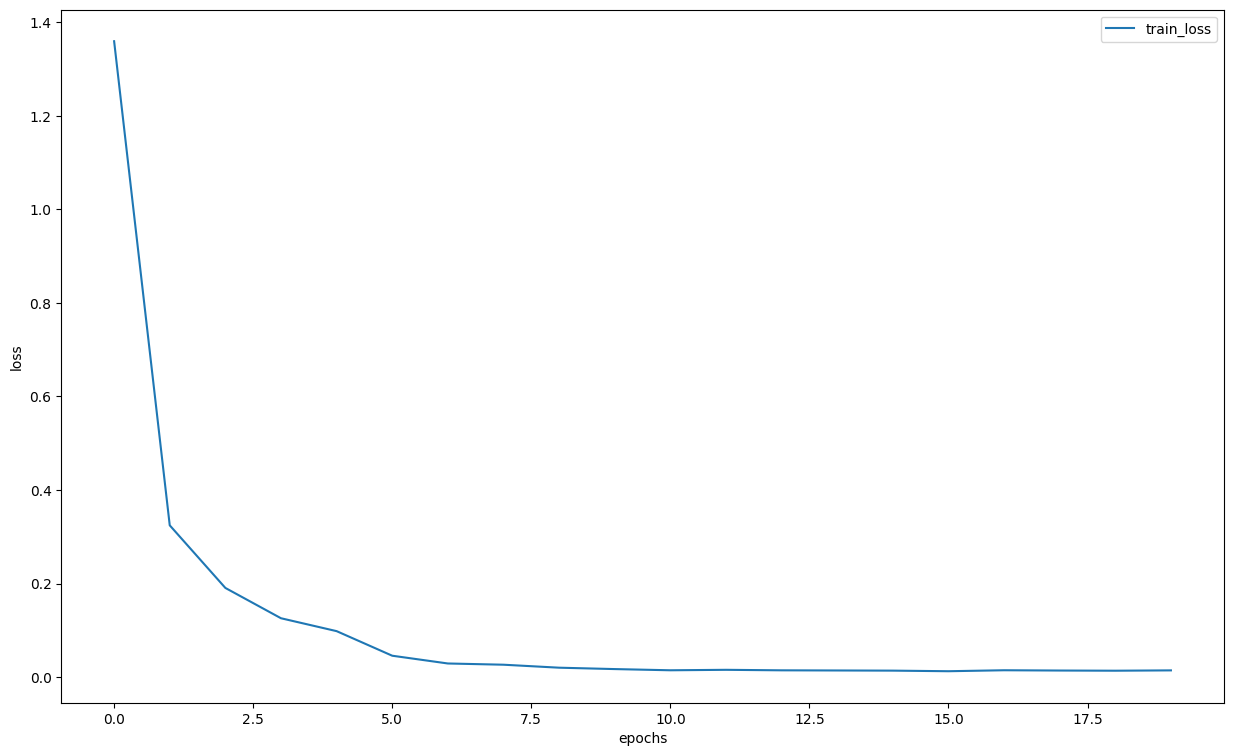

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
accuracy = []
for i in range(len(acc)):
    accuracy.append(acc[i].cpu().detach().numpy())
accuracy

[array(0.62824917, dtype=float32),
 array(0.90730613, dtype=float32),
 array(0.94507694, dtype=float32),
 array(0.96314085, dtype=float32),
 array(0.9708688, dtype=float32),
 array(0.98688674, dtype=float32),
 array(0.99199635, dtype=float32),
 array(0.99287623, dtype=float32),
 array(0.9944133, dtype=float32),
 array(0.9953038, dtype=float32),
 array(0.99595046, dtype=float32),
 array(0.9954522, dtype=float32),
 array(0.9959081, dtype=float32),
 array(0.9963003, dtype=float32),
 array(0.9961731, dtype=float32),
 array(0.9964169, dtype=float32),
 array(0.9961943, dtype=float32),
 array(0.9960565, dtype=float32),
 array(0.9964699, dtype=float32),
 array(0.9960989, dtype=float32)]

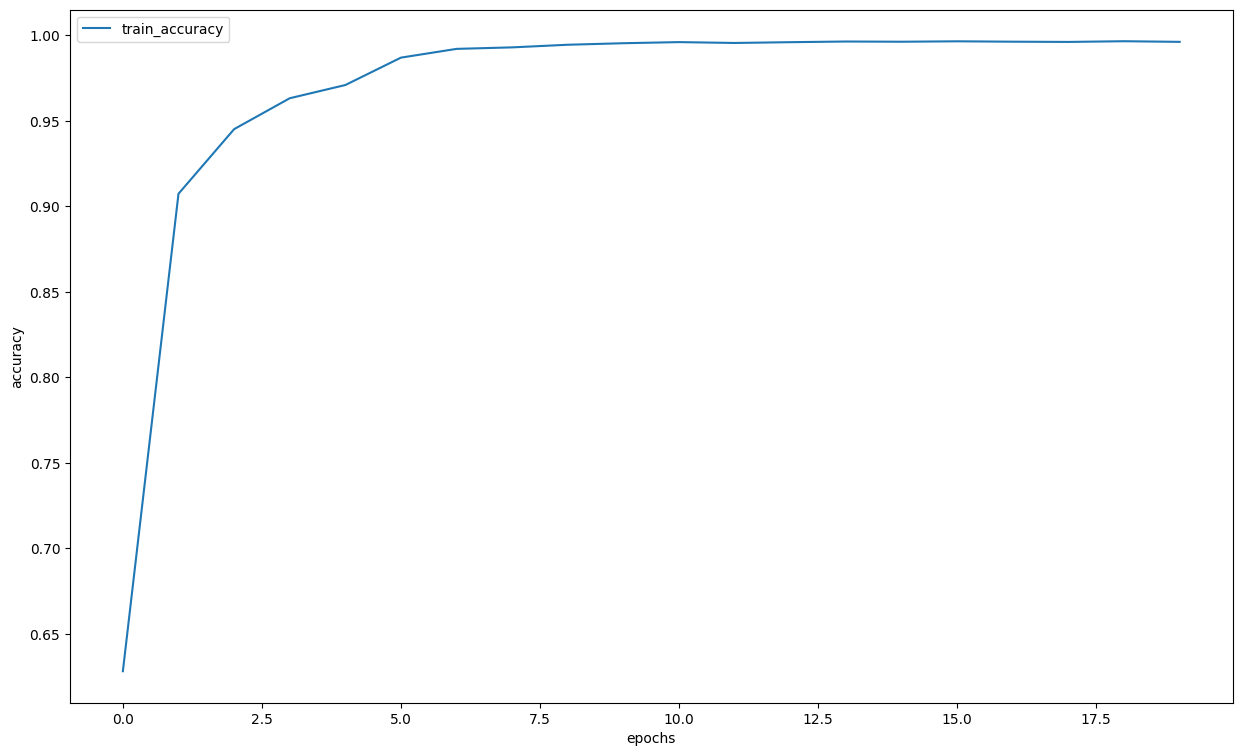

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(accuracy, label="train_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
label_encoder = pickle.load(open("/content/le.pickle", 'rb'))

In [ ]:
submission(model=scnn_v2, test_dataset=test_dataset)

           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon


##Дообучение сети ResNet18
Для сравнения подгрузим ResNet18 и попробуем дообучить данную сеть для решения нашей задачи.

In [ ]:
model_rn_18 = models.resnet18(pretrained=True)
print(model_rn_18)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_feat = model_rn_18.fc.in_features
model_rn_18.fc = nn.Linear(num_feat, n_classes)
model_rn_18 = model_rn_18.to(DEVICE)
for name, p in model_rn_18.named_parameters():
  if name.startswith("layer4.0") or name.startswith("layer4.1") or name.startswith("fc."):
    p.requires_grad = True
  else:
    p.requires_grad = False
  print("parameter:", name, "==>", "requires_grad:", p.requires_grad)

parameter: conv1.weight ==> requires_grad: False
parameter: bn1.weight ==> requires_grad: False
parameter: bn1.bias ==> requires_grad: False
parameter: layer1.0.conv1.weight ==> requires_grad: False
parameter: layer1.0.bn1.weight ==> requires_grad: False
parameter: layer1.0.bn1.bias ==> requires_grad: False
parameter: layer1.0.conv2.weight ==> requires_grad: False
parameter: layer1.0.bn2.weight ==> requires_grad: False
parameter: layer1.0.bn2.bias ==> requires_grad: False
parameter: layer1.1.conv1.weight ==> requires_grad: False
parameter: layer1.1.bn1.weight ==> requires_grad: False
parameter: layer1.1.bn1.bias ==> requires_grad: False
parameter: layer1.1.conv2.weight ==> requires_grad: False
parameter: layer1.1.bn2.weight ==> requires_grad: False
parameter: layer1.1.bn2.bias ==> requires_grad: False
parameter: layer2.0.conv1.weight ==> requires_grad: False
parameter: layer2.0.bn1.weight ==> requires_grad: False
parameter: layer2.0.bn1.bias ==> requires_grad: False
parameter: layer2.0

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = F.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def train_v3(model, loss, optimizer, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, loss, optimizer)
            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))

    return history

In [ ]:
ls = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_rn_18.parameters(), amsgrad=True, lr=1e-3)

In [ ]:
history = train_v3(model=model_rn_18, loss=ls, optimizer=optim, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 001 train_loss: 0.1772 train_acc 0.9605

Epoch 002 train_loss: 0.0381 train_acc 0.9901

Epoch 003 train_loss: 0.0232 train_acc 0.9937

Epoch 004 train_loss: 0.0137 train_acc 0.9962

Epoch 005 train_loss: 0.0124 train_acc 0.9966

Epoch 006 train_loss: 0.0081 train_acc 0.9978

Epoch 007 train_loss: 0.0071 train_acc 0.9983

Epoch 008 train_loss: 0.0061 train_acc 0.9984

Epoch 009 train_loss: 0.0051 train_acc 0.9986

Epoch 010 train_loss: 0.0050 train_acc 0.9986

Epoch 011 train_loss: 0.0045 train_acc 0.9986

Epoch 012 train_loss: 0.0034 train_acc 0.9990

Epoch 013 train_loss: 0.0032 train_acc 0.9991

Epoch 014 train_loss: 0.0024 train_acc 0.9993

Epoch 015 train_loss: 0.0017 train_acc 0.9995

Epoch 016 train_loss: 0.0017 train_acc 0.9995

Epoch 017 train_loss: 0.0016 train_acc 0.9997

Epoch 018 train_loss: 0.0011 train_acc 0.9997

Epoch 019 train_loss: 0.0008 train_acc 0.9998

Epoch 020 train_loss: 0.0011 train_acc 0.9997


In [ ]:
loss, acc = zip(*history)

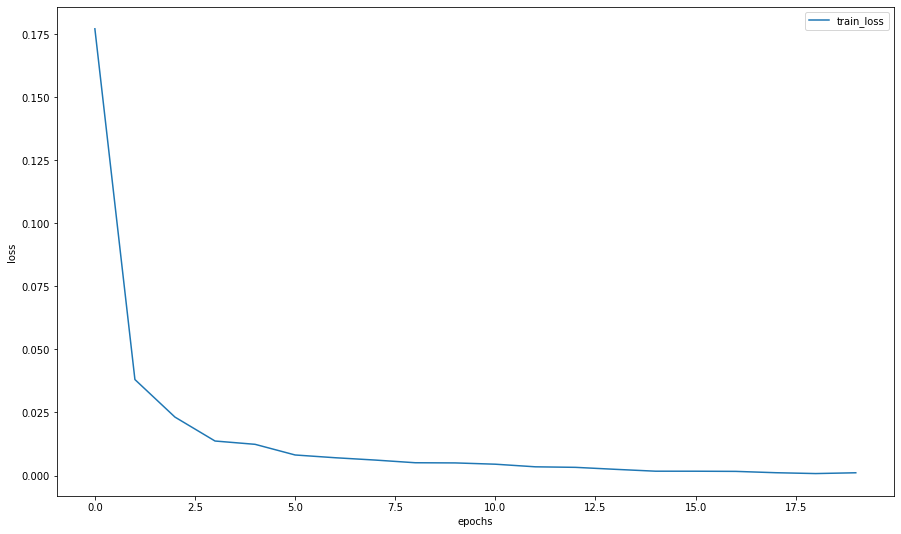

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_rn_18, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_rn_18, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
f1_score(actual_labels, y_pred, average="micro")

1.0

In [ ]:
submission(model=model_rn_18, test_dataset=test_dataset)

           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon


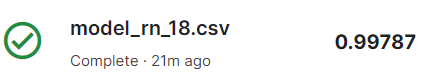

Получается, что самодельная нейронная сеть получилась немного точнее, чем дообученная с 4-го слоя сеть ResNet18. Это не может не радовать.